In [11]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from pmdarima import model_selection
import time
import auxiliar as ax
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Real, Integer
from skopt import gp_minimize
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH = '../bds/'
tickers = ['TSLA', 'NIO', 'LI', 'RIVN', 'BYDDY']


In [12]:
times_series = {}
for name in tickers:
    serie = pd.read_csv(DATA_PATH + name + '.csv' ,sep=',',usecols=[0,4])
    times_series[name] = serie

significantLags: [1, 5]
         Date       Close   (Close-1)   (Close-5)
5  2020-10-08  141.973328  141.766663  149.386673
6  2020-10-09  144.666672  141.973328  138.363327
significantLags: [1, 2, 3, 4, 5, 6, 8]
         Date      Close  (Close-1)  (Close-2)  (Close-3)  (Close-4)  \
8  2020-10-13  21.620001  21.850000  21.469999  21.440001  21.559999   
9  2020-10-14  26.500000  21.620001  21.850000  21.469999  21.440001   

   (Close-5)  (Close-6)  (Close-8)  
8  20.670000      21.59      21.76  
9  21.559999      20.67      21.18  
significantLags: [1, 5]
         Date  Close  (Close-1)  (Close-5)
5  2020-10-08  17.93      17.77  16.799999
6  2020-10-09  17.60      17.93  16.920000
significantLags: [1, 2, 4, 6, 10]
          Date       Close   (Close-1)   (Close-2)   (Close-4)   (Close-6)  \
10  2021-11-24  114.849998  119.849998  118.110001  123.379997  172.009995   
11  2021-11-26  112.129997  114.849998  119.849998  128.600006  146.070007   

    (Close-10)  
10  100.730003  
11 

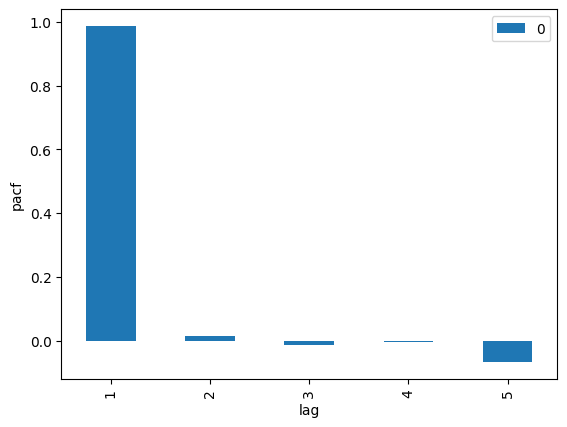

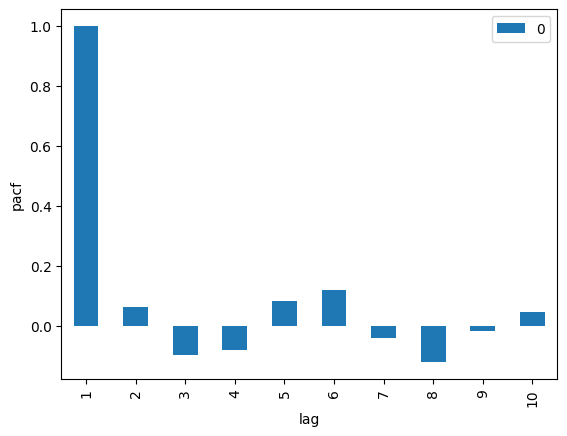

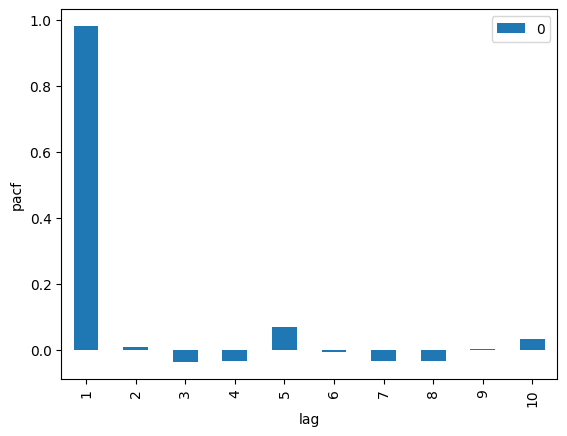

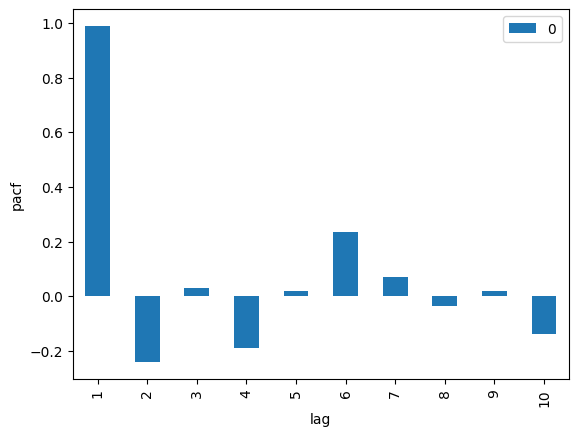

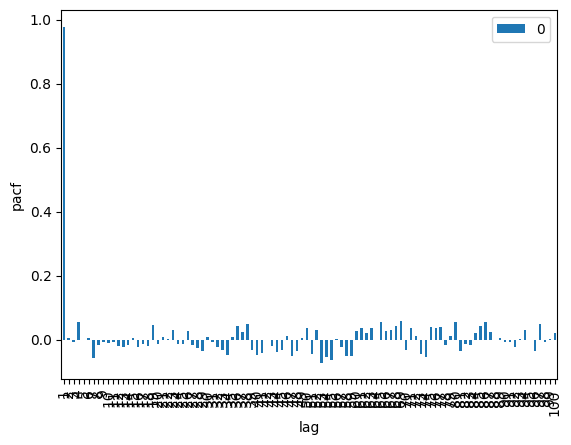

In [13]:
n_lags_significantes = {
    'TSLA': 5, 'NIO':10, 'LI': 10, 'RIVN': 10, 'BYDDY': 100
}
for name in tickers:
    lags = ax.getSignificantLags(y=times_series[name]['Close'], nLags =n_lags_significantes[name], alpha=0.05)
    times_series[name] = ax.appendLagVariables(yNm='Close', significantLags = lags, df = times_series[name], dropna=True)


In [14]:
X = {}
y = {}
for name in tickers:
    times_series[name] = times_series[name].dropna()
    X[name] = times_series[name].drop('Close', axis=1)
    X[name] = times_series[name].drop('Date', axis=1)
    y[name] = times_series[name]['Close']

In [15]:
X_train = {}
X_test = {}
y_train = {}
y_test = {}

for name in tickers:
    X_train[name], X_test[name], y_train[name], y_test[name] = train_test_split(X[name], y[name], 
                                                                                test_size=0.2, shuffle=False)

In [16]:
X_scale = {}
y_scale = {}
for name in tickers:
    X_scale[name] = StandardScaler()
    y_scale[name] = StandardScaler()

X_train_scale = {}
X_test_scale = {}
y_train_scale = {}
y_test_scale = {}

for name in tickers:
    X_train_scale[name] = X_scale[name].fit_transform(X_train[name])
    X_test_scale[name] = X_scale[name].fit_transform(X_test[name])

    y_train_scale[name] = y_scale[name].fit_transform(y_train[name].values.reshape(-1, 1))
    y_test_scale[name] = y_scale[name].fit_transform(y_test[name].values.reshape(-1, 1))

In [17]:
QTD_ITERACAO = 10

## SEM SVD

In [18]:
import krlst_implement as KRLS

In [19]:
#model_sem_svd = {}
modelos_sem_svd_por_iteracao = {name: [] for name in tickers}
Ms = {
    'TSLA': 10, 'NIO':10, 'LI': 10, 'RIVN': 10, 'BYDDY': 10
}
for name in tickers:
    for i in range(QTD_ITERACAO):
        modelos_sem_svd_por_iteracao[name].append(KRLS.Krls_t(lambda_= 0.0001, c=0.00001,M=Ms[name], sigma = 1))

In [20]:
#tmp_partial_fit_s_SVD = {}
tmp_partial_fit_s_SVD = {name: [[] for _ in range(QTD_ITERACAO)] for name in tickers}

for name in tickers:
    for j in range(QTD_ITERACAO):
        print(f'Times Serie: {name}')
        start_time = time.time()
        for i in range(len(X_train[name])):
            modelos_sem_svd_por_iteracao[name][j].learn_one(X_train_scale[name][i], y_train_scale[name][i], int(X_train[name].index[i]))
        end_time = time.time()
        tmp_partial_fit_s_SVD[name][j].append(end_time - start_time)

Times Serie: TSLA


Times Serie: TSLA
Times Serie: TSLA
Times Serie: TSLA
Times Serie: TSLA
Times Serie: TSLA
Times Serie: TSLA
Times Serie: TSLA
Times Serie: TSLA
Times Serie: TSLA
Times Serie: NIO


KeyboardInterrupt: 

In [ ]:
tmp_previsoes_s_SVD = {name: [] for name in tickers}  # Armazena o tempo de execução para cada iteração e ticker
previsoes_s_SVD = {name: [[] for _ in range(QTD_ITERACAO)] for name in tickers}  # Armazena previsões para cada iteração e ticker

for name in tickers:
    for j in range(QTD_ITERACAO):
        previsoes = []
        
        for i in range(len(X_test[name])):
            start_time = time.time()
            # Realiza a previsão para o dado de teste atual
            y_pred, desv = modelos_sem_svd_por_iteracao[name][j].predict(X_test_scale[name][i])
            # Atualiza o modelo com o dado atual
            modelos_sem_svd_por_iteracao[name][j].learn_one(
                X_test_scale[name][i], y_test_scale[name][i], int(X_test[name].index[i])
            )
            # Armazena a previsão
            previsoes.append(y_pred)
            end_time = time.time()
            tmp_previsoes_s_SVD[name].append(end_time - start_time)
        # Converte as previsões para numpy array e armazena no dicionário
        previsoes_s_SVD[name][j] = np.array(previsoes)

        

In [ ]:
for name in tickers:
    previsoes_s_SVD[name] = [arr[0, 0] for arr in previsoes_s_SVD[name][0]]
    previsoes_s_SVD[name] = y_scale[name].inverse_transform(np.array([previsoes_s_SVD[name]]))
    previsoes_s_SVD[name] = previsoes_s_SVD[name][0].reshape(-1,1)

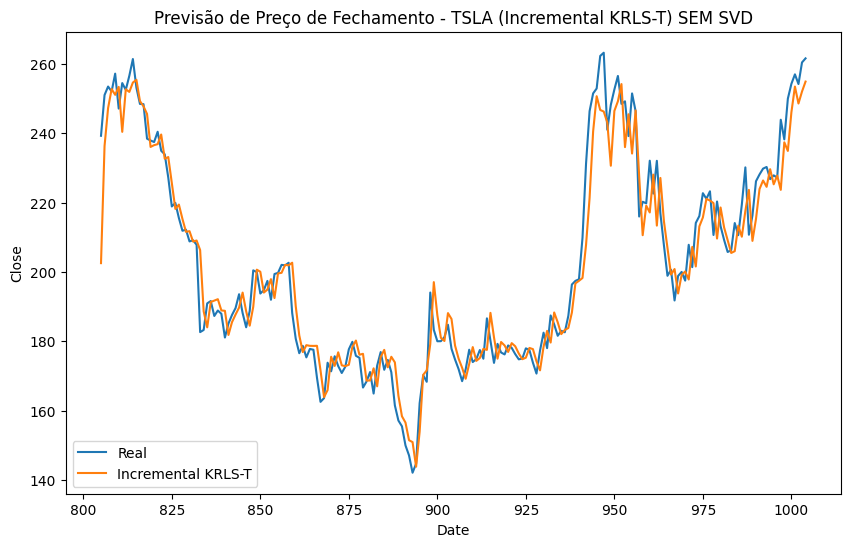

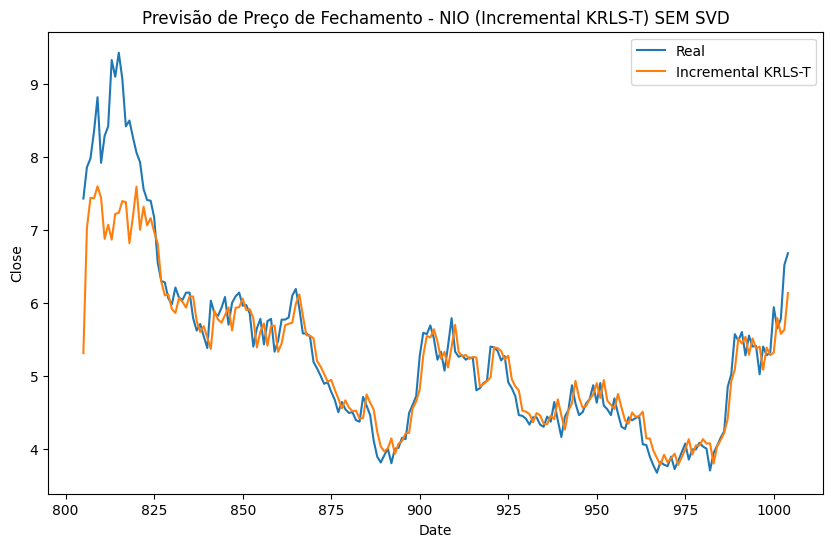

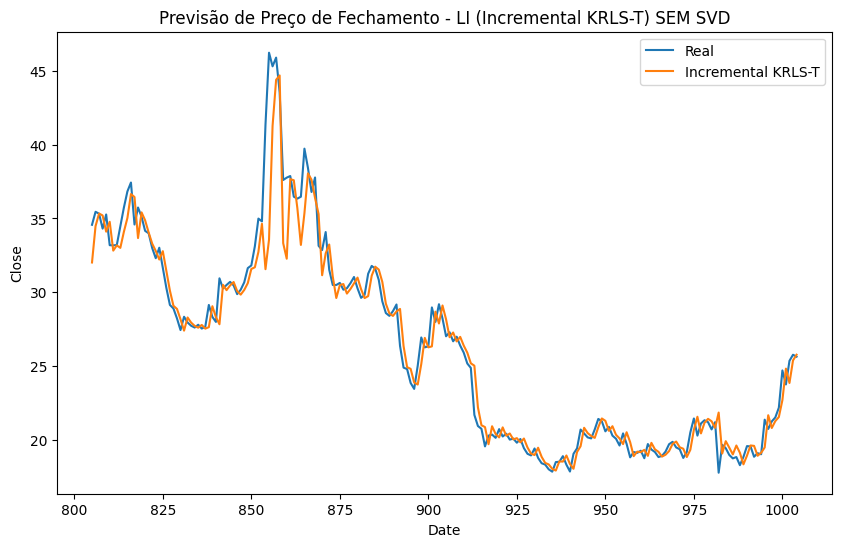

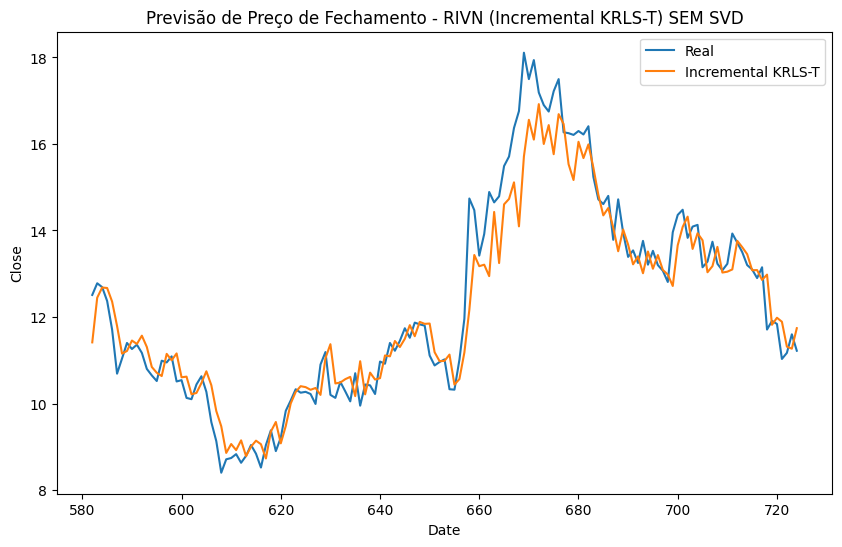

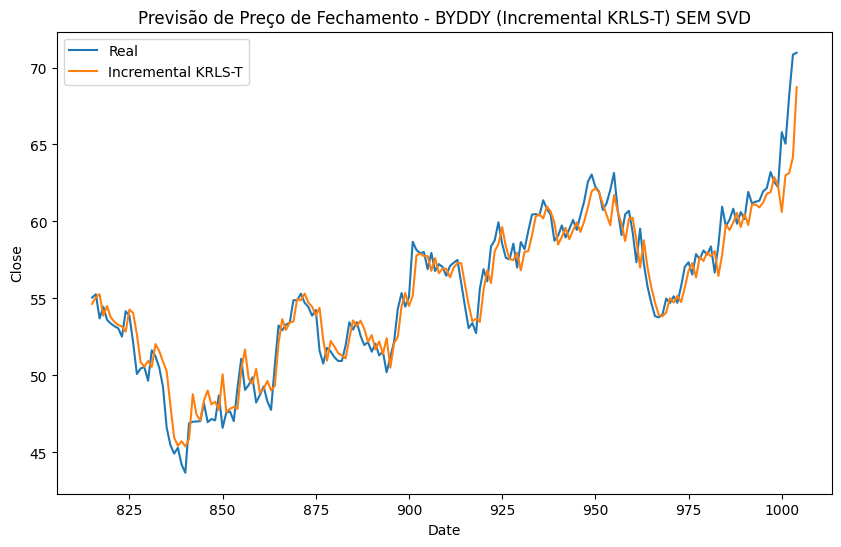

In [ ]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[name].index, y_test[name], label='Real')
    plt.plot(y_test[name].index, previsoes_s_SVD[name], label='Incremental KRLS-T')
    plt.title(f'Previsão de Preço de Fechamento - {name} (Incremental KRLS-T) SEM SVD')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend()
    plt.show()

In [ ]:
metricas = {}
for name in tickers:
    metricas[name] = ax.calcular_metricas_regressao(y_test[name], previsoes_s_SVD[name])

In [ ]:
metricas_table = {
    'TS': [ticker for ticker in tickers],
    'SVD': False,
    'MSE': [metricas[ticker][metricas[ticker]['Métrica'] == 'MSE']['Valor'].values[0] for ticker in tickers],
    'MAE': [metricas[ticker][metricas[ticker]['Métrica'] == 'MAE']['Valor'].values[0] for ticker in tickers],
    'MAPE': [metricas[ticker][metricas[ticker]['Métrica'] == 'MAPE']['Valor'].values[0] for ticker in tickers],
    'RMSE': [metricas[ticker][metricas[ticker]['Métrica'] == 'RMSE']['Valor'].values[0] for ticker in tickers],
    'R^2': [metricas[ticker][metricas[ticker]['Métrica'] == 'R^2']['Valor'].values[0] for ticker in tickers],
    'U de THEIL': [metricas[ticker][metricas[ticker]['Métrica'] == 'THEIL']['Valor'].values[0] for ticker in tickers],
    'ARV': [metricas[ticker][metricas[ticker]['Métrica'] == 'ARV']['Valor'].values[0] for ticker in tickers],
    'WPOCID': [metricas[ticker][metricas[ticker]['Métrica'] == 'WPOCID']['Valor'].values[0] for ticker in tickers]
}

metricas_table = pd.DataFrame(metricas_table)
metricas_table

,TS,SVD,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID
0,TSLA,False,60.382036,5.659844,0.027481,7.770588,0.933832,1.013536,0.066168,0.532663
1,NIO,False,0.222425,0.268723,0.044282,0.471620,0.855757,3.191073,0.144243,0.477387
2,LI,False,2.644439,0.909035,0.032175,1.626173,0.942164,1.675186,0.057836,0.462312
3,RIVN,False,0.465282,0.475560,0.037348,0.682116,0.917367,1.553059,0.082633,0.514085
4,BYDDY,False,1.882596,0.995024,0.017989,1.372077,0.928417,1.309065,0.071583,0.571429


In [ ]:
tempos_table_s_SVD = {
    'TS': [],
    'SVD': False,
    'ITERAÇÃO': [],
    'TEMPO - PARTIAL FIT (s)': [],
    'TEMPO - PREVISÃO (s)': []
}

for name in tickers:
    for j in range(QTD_ITERACAO):
        tempos_table_s_SVD['TS'].append(name)
        tempos_table_s_SVD['ITERAÇÃO'].append(j + 1)

        tempo_partial_fit = tmp_partial_fit_s_SVD[name][j][0] if j < len(tmp_partial_fit_s_SVD[name]) else 'N/A'
        
        # Tempo de previsão é um valor simples
        tempo_previsao = tmp_previsoes_s_SVD[name][j] if j < len(tmp_previsoes_s_SVD[name]) else 'N/A'
        
        # Adiciona os tempos à tabela
        tempos_table_s_SVD['TEMPO - PARTIAL FIT (s)'].append(tempo_partial_fit)
        tempos_table_s_SVD['TEMPO - PREVISÃO (s)'].append(tempo_previsao)

# Converte a tabela de tempos para um DataFrame
tempos_table_s_SVD = pd.DataFrame(tempos_table_s_SVD)
tempos_table_s_SVD

,TS,SVD,ITERAÇÃO,TEMPO - PARTIAL FIT (s),TEMPO - PREVISÃO (s)
0,TSLA,False,1,0.649857,0.004529
1,TSLA,False,2,0.506054,0.002583
2,TSLA,False,3,0.524268,0.002020
3,TSLA,False,4,0.575781,0.001004
4,TSLA,False,5,0.628292,0.001990
5,TSLA,False,6,0.519242,0.001004
6,TSLA,False,7,0.499795,0.000999
7,TSLA,False,8,0.470567,0.001104
8,TSLA,False,9,0.429830,0.000964
9,TSLA,False,10,0.438826,0.001002


## COM SVD

In [ ]:
#model_sem_svd = {}
model_com_svd_por_iteracao = {name: [] for name in tickers}
Ms = {
    'TSLA': 10, 'NIO':10, 'LI': 10, 'RIVN': 10, 'BYDDY': 10
}
for name in tickers:
    for i in range(QTD_ITERACAO):
        model_com_svd_por_iteracao[name].append(KRLS.Krls_t(lambda_= 0.0001, c=0.00001,M=Ms[name], sigma = 1))

In [ ]:
#tmp_partial_fit_s_SVD = {}
tmp_partial_fit_c_SVD = {name: [[] for _ in range(QTD_ITERACAO)] for name in tickers}

for name in tickers:
    for j in range(QTD_ITERACAO):
        print(f'Times Serie: {name}')
        start_time = time.time()
        for i in range(len(X_train[name])):
            model_com_svd_por_iteracao[name][j].learn_one(X_train_scale[name][i], y_train_scale[name][i], int(X_train[name].index[i]))
        end_time = time.time()
        tmp_partial_fit_c_SVD[name][j].append(end_time - start_time)

Times Serie: TSLA


KeyboardInterrupt: 

In [ ]:
tmp_previsoes_c_SVD = {name: [] for name in tickers}  
previsoes_c_SVD = {name: [[] for _ in range(QTD_ITERACAO)] for name in tickers}  

for name in tickers:
    for j in range(QTD_ITERACAO):
        previsoes = []
        
        for i in range(len(X_test[name])):
            start_time = time.time()
            
            y_pred, desv = model_com_svd_por_iteracao[name][j].predict(X_test_scale[name][i])
            
            model_com_svd_por_iteracao[name][j].learn_one(
                X_test_scale[name][i], y_test_scale[name][i], int(X_test[name].index[i])
            )
            
            previsoes.append(y_pred)
            end_time = time.time()
            tmp_previsoes_c_SVD[name].append(end_time - start_time)
        
        previsoes_c_SVD[name][j] = np.array(previsoes)

        

In [ ]:
for name in tickers:
    previsoes_c_SVD[name] = [arr[0, 0] for arr in previsoes_c_SVD[name][0]]
    previsoes_c_SVD[name] = y_scale[name].inverse_transform(np.array([previsoes_c_SVD[name]]))
    previsoes_c_SVD[name] = previsoes_c_SVD[name][0].reshape(-1,1)

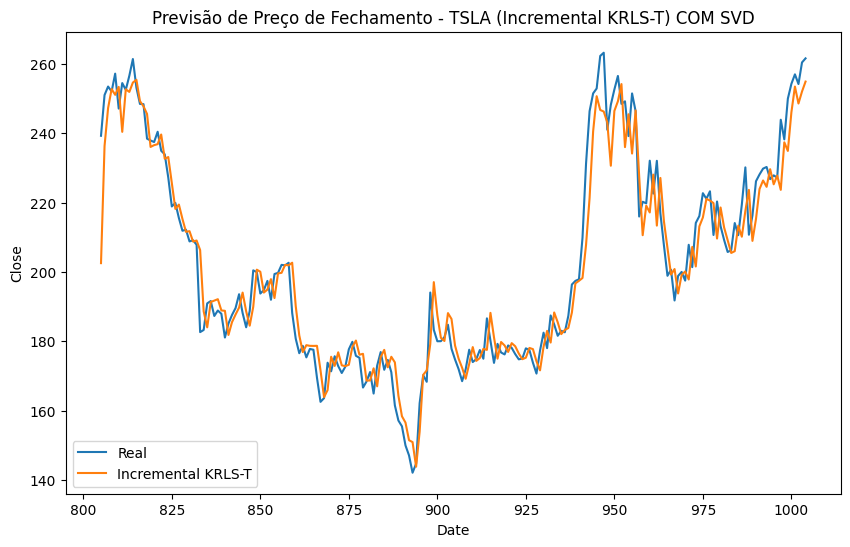

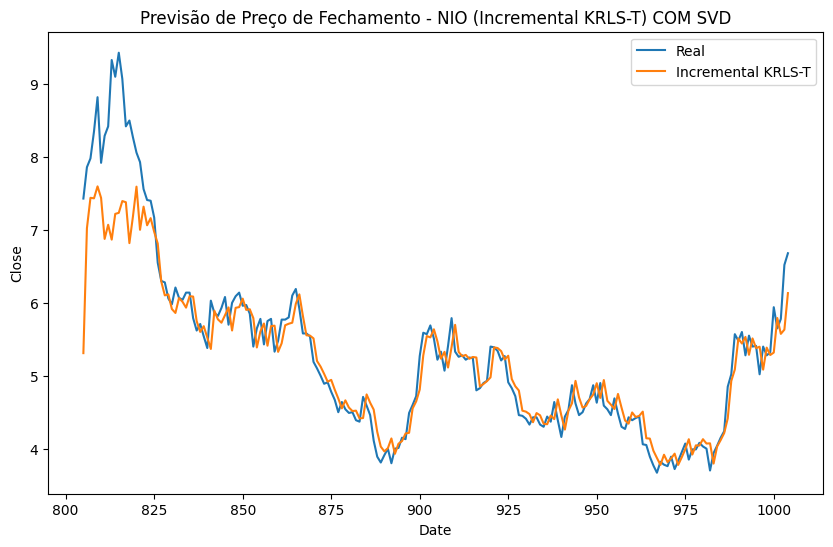

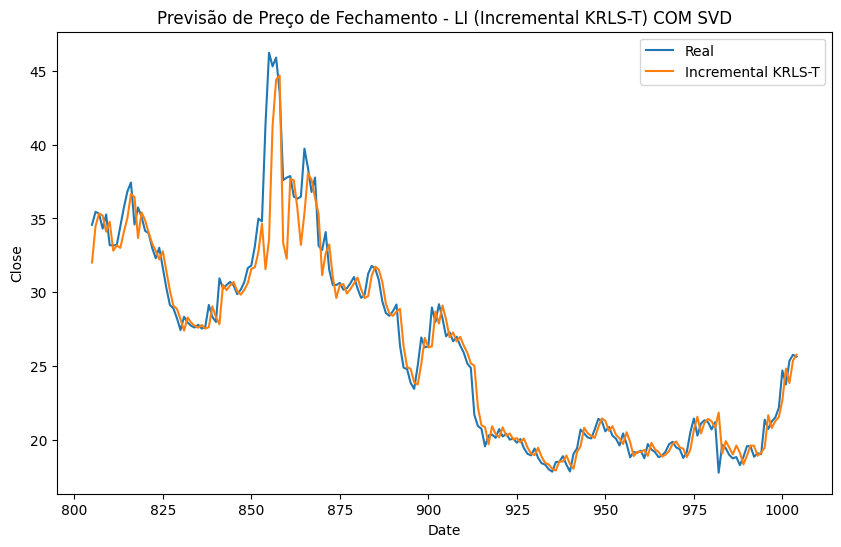

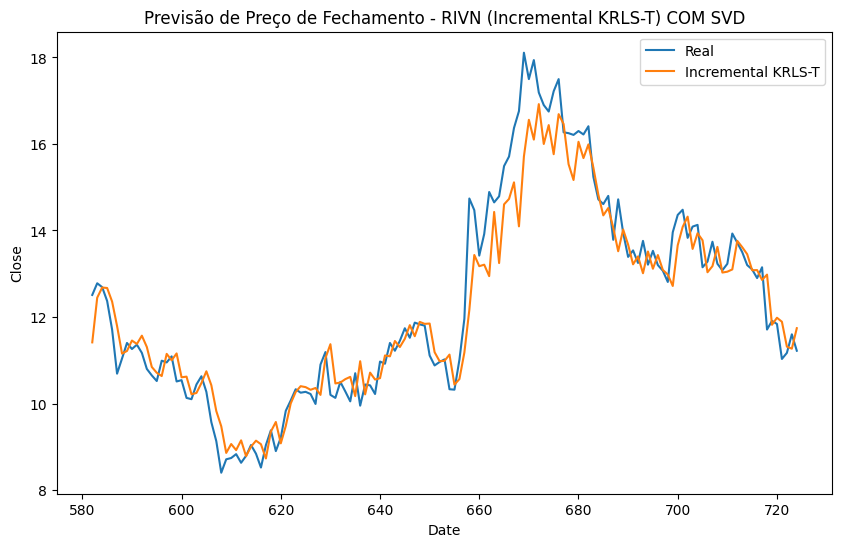

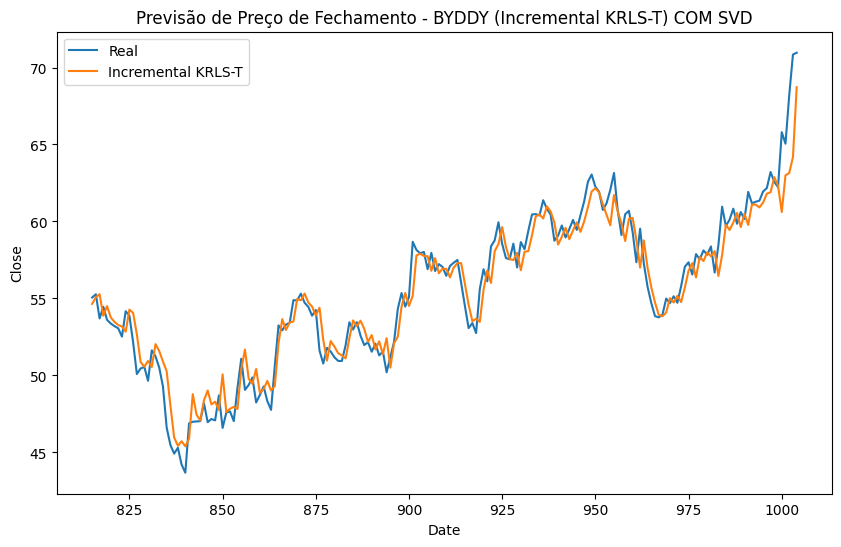

In [ ]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[name].index, y_test[name], label='Real')
    plt.plot(y_test[name].index, previsoes_c_SVD[name], label='Incremental KRLS-T')
    plt.title(f'Previsão de Preço de Fechamento - {name} (Incremental KRLS-T) COM SVD')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend()
    plt.show()

In [ ]:
metricas_c_svd = {}
for name in tickers:
    metricas_c_svd[name] = ax.calcular_metricas_regressao(y_test[name], previsoes_s_SVD[name])

In [ ]:
metricas_table_c_SVD = {
    'TS': [ticker for ticker in tickers],
    'SVD': True,
    'MSE': [metricas_c_svd[ticker][metricas_c_svd[ticker]['Métrica'] == 'MSE']['Valor'].values[0] for ticker in tickers],
    'MAE': [metricas_c_svd[ticker][metricas_c_svd[ticker]['Métrica'] == 'MAE']['Valor'].values[0] for ticker in tickers],
    'MAPE': [metricas_c_svd[ticker][metricas_c_svd[ticker]['Métrica'] == 'MAPE']['Valor'].values[0] for ticker in tickers],
    'RMSE': [metricas_c_svd[ticker][metricas_c_svd[ticker]['Métrica'] == 'RMSE']['Valor'].values[0] for ticker in tickers],
    'R^2': [metricas_c_svd[ticker][metricas_c_svd[ticker]['Métrica'] == 'R^2']['Valor'].values[0] for ticker in tickers],
    'U de THEIL': [metricas_c_svd[ticker][metricas_c_svd[ticker]['Métrica'] == 'THEIL']['Valor'].values[0] for ticker in tickers],
    'ARV': [metricas_c_svd[ticker][metricas_c_svd[ticker]['Métrica'] == 'ARV']['Valor'].values[0] for ticker in tickers],
    'WPOCID': [metricas_c_svd[ticker][metricas_c_svd[ticker]['Métrica'] == 'WPOCID']['Valor'].values[0] for ticker in tickers],
}
metricas_table_c_SVD = pd.DataFrame(metricas_table_c_SVD)
metricas_table_c_SVD

,TS,SVD,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID
0,TSLA,True,60.382036,5.659844,0.027481,7.770588,0.933832,1.013536,0.066168,0.532663
1,NIO,True,0.222425,0.268723,0.044282,0.471620,0.855757,3.191073,0.144243,0.477387
2,LI,True,2.644439,0.909035,0.032175,1.626173,0.942164,1.675186,0.057836,0.462312
3,RIVN,True,0.465282,0.475560,0.037348,0.682116,0.917367,1.553059,0.082633,0.514085
4,BYDDY,True,1.882596,0.995024,0.017989,1.372077,0.928417,1.309065,0.071583,0.571429


In [ ]:
tempos_table_c_SVD = {
    'TS': [],
    'SVD': True,
    'ITERAÇÃO': [],
    'TEMPO - PARTIAL FIT (s)': [],
    'TEMPO - PREVISÃO (s)': []
}

for name in tickers:
    for j in range(QTD_ITERACAO):
        tempos_table_c_SVD['TS'].append(name)
        tempos_table_c_SVD['ITERAÇÃO'].append(j + 1)

        tempo_partial_fit = tmp_partial_fit_c_SVD[name][j][0] if j < len(tmp_partial_fit_c_SVD[name]) else 'N/A'
        
        # Tempo de previsão é um valor simples
        tempo_previsao = tmp_previsoes_c_SVD[name][j] if j < len(tmp_previsoes_c_SVD[name]) else 'N/A'
        
        # Adiciona os tempos à tabela
        tempos_table_c_SVD['TEMPO - PARTIAL FIT (s)'].append(tempo_partial_fit)
        tempos_table_c_SVD['TEMPO - PREVISÃO (s)'].append(tempo_previsao)

# Converte a tabela de tempos para um DataFrame
tempos_table_c_SVD = pd.DataFrame(tempos_table_c_SVD)
tempos_table_c_SVD

,TS,SVD,ITERAÇÃO,TEMPO - PARTIAL FIT (s),TEMPO - PREVISÃO (s)
0,TSLA,True,1,0.416157,0.003537
1,TSLA,True,2,0.382150,0.001002
2,TSLA,True,3,0.379632,0.000000
3,TSLA,True,4,0.432673,0.000998
4,TSLA,True,5,0.450754,0.001000
5,TSLA,True,6,0.416166,0.000996
6,TSLA,True,7,0.399153,0.000000
7,TSLA,True,8,0.401154,0.001000
8,TSLA,True,9,0.381109,0.000000
9,TSLA,True,10,0.406165,0.000999


## DESEMPENHO

In [ ]:
tempos_table_concatenada = pd.concat([tempos_table_s_SVD, tempos_table_c_SVD], axis=0, ignore_index=True)
tempos_table_concatenada = tempos_table_concatenada.sort_values(by=['TS', 'ITERAÇÃO', 'SVD']).reset_index(drop=True)
tempos_table_concatenada

,TS,SVD,ITERAÇÃO,TEMPO - PARTIAL FIT (s),TEMPO - PREVISÃO (s)
0,BYDDY,False,1,0.395165,0.000000
1,BYDDY,True,1,0.352634,0.000000
2,BYDDY,False,2,0.395165,0.001002
3,BYDDY,True,2,0.362843,0.000999
4,BYDDY,False,3,0.379160,0.000000
...,...,...,...,...,...
95,TSLA,True,8,0.401154,0.001000
96,TSLA,False,9,0.432258,0.001005
97,TSLA,True,9,0.381109,0.000000
98,TSLA,False,10,0.438189,0.000000


Text(0.5, 0, 'USANDO SVD')

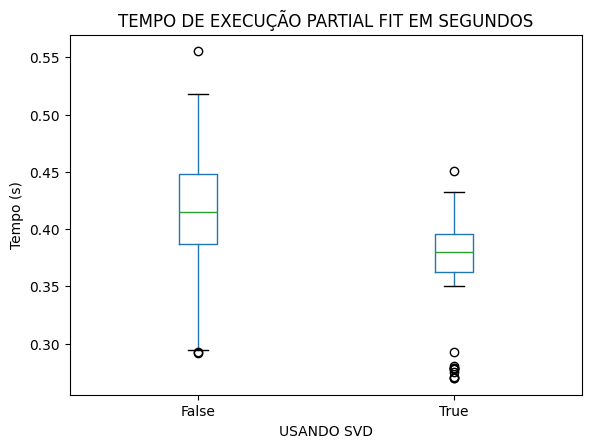

In [ ]:
tempos_table_concatenada.boxplot(column='TEMPO - PARTIAL FIT (s)', by='SVD', grid=False)
plt.title("TEMPO DE EXECUÇÃO PARTIAL FIT EM SEGUNDOS")
plt.suptitle("")
plt.ylabel("Tempo (s)")
plt.xlabel("USANDO SVD")

Text(0.5, 0, 'USANDO SVD')

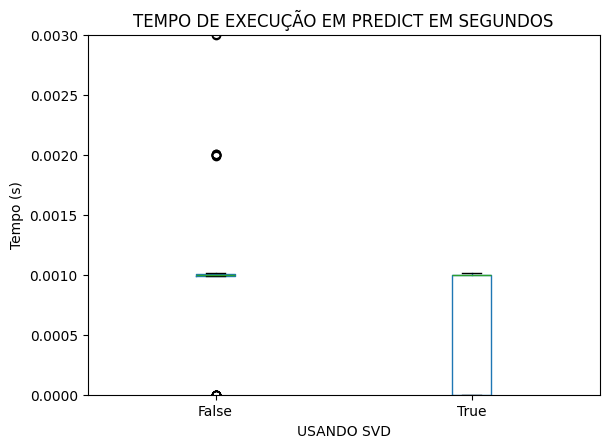

In [ ]:
tempos_table_concatenada.boxplot(column='TEMPO - PREVISÃO (s)', by='SVD', grid=False)
plt.title("TEMPO DE EXECUÇÃO EM PREDICT EM SEGUNDOS")
plt.suptitle("")
plt.ylabel("Tempo (s)")
plt.ylim(0, 0.003) 
plt.xlabel("USANDO SVD")


In [ ]:
metricas_table_concatenada = pd.concat([metricas_table, metricas_table_c_SVD], axis=0, ignore_index=True)
metricas_table_concatenada

,TS,SVD,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID
0,TSLA,False,60.382036,5.659844,0.027481,7.770588,0.933832,1.013536,0.066168,0.532663
1,NIO,False,0.222425,0.268723,0.044282,0.471620,0.855757,3.191073,0.144243,0.477387
2,LI,False,2.644439,0.909035,0.032175,1.626173,0.942164,1.675186,0.057836,0.462312
3,RIVN,False,0.465282,0.475560,0.037348,0.682116,0.917367,1.553059,0.082633,0.514085
4,BYDDY,False,1.882596,0.995024,0.017989,1.372077,0.928417,1.309065,0.071583,0.571429
5,TSLA,True,60.382036,5.659844,0.027481,7.770588,0.933832,1.013536,0.066168,0.532663
6,NIO,True,0.222425,0.268723,0.044282,0.471620,0.855757,3.191073,0.144243,0.477387
7,LI,True,2.644439,0.909035,0.032175,1.626173,0.942164,1.675186,0.057836,0.462312
8,RIVN,True,0.465282,0.475560,0.037348,0.682116,0.917367,1.553059,0.082633,0.514085
9,BYDDY,True,1.882596,0.995024,0.017989,1.372077,0.928417,1.309065,0.071583,0.571429


In [ ]:
metricas_table_concatenada = metricas_table_concatenada.sort_values(by=['TS']).reset_index(drop=True)
metricas_table_concatenada

,TS,SVD,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID
0,BYDDY,False,1.882596,0.995024,0.017989,1.372077,0.928417,1.309065,0.071583,0.571429
1,BYDDY,True,1.882596,0.995024,0.017989,1.372077,0.928417,1.309065,0.071583,0.571429
2,LI,False,2.644439,0.909035,0.032175,1.626173,0.942164,1.675186,0.057836,0.462312
3,LI,True,2.644439,0.909035,0.032175,1.626173,0.942164,1.675186,0.057836,0.462312
4,NIO,False,0.222425,0.268723,0.044282,0.471620,0.855757,3.191073,0.144243,0.477387
5,NIO,True,0.222425,0.268723,0.044282,0.471620,0.855757,3.191073,0.144243,0.477387
6,RIVN,False,0.465282,0.475560,0.037348,0.682116,0.917367,1.553059,0.082633,0.514085
7,RIVN,True,0.465282,0.475560,0.037348,0.682116,0.917367,1.553059,0.082633,0.514085
8,TSLA,False,60.382036,5.659844,0.027481,7.770588,0.933832,1.013536,0.066168,0.532663
9,TSLA,True,60.382036,5.659844,0.027481,7.770588,0.933832,1.013536,0.066168,0.532663
